# Discriminative Estimators

Discriminative estimators are mutual information estimators based on the Donsker-Varadhan representation of the KL divergence that describes mutual information:

$$
I(x;y) = KL(p(y|x)||p(y)) \ge \max_{F\in\mathcal{F}} \mathbb{E}_{p(x,y)}[F(x,y)] -\mathbb{E}_{p(x)}\left[\log\mathbb{E}_{p(y)}[e^{F(x,y)}]\right],
$$

Mutual information estimators in literature differ in the modeling choice and optimization strategy for $F(x,y)$, and in the method used to estimate the expectations above.


In order to showcase the different modeling choices, we will estimate mutual information between samples from a 2D  mixture of correlated Normals $p(x,y):=\sum_{i=1}^K \pi_i\ \mathcal{N}([x_i, y_i]^T|\mu_i,\Sigma_i)$, which is challenging enough to underline some effect of the modeling choices.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import numpy as np
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
IMG_SIZE=3

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


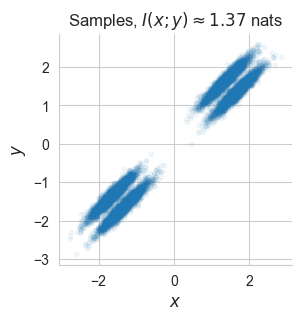

In [2]:
from torch_mist.data.multimixture import MultivariateCorrelatedNormalMixture

# Definition of the distribution
x_dim = y_dim = n_dim = 1
p_XY = MultivariateCorrelatedNormalMixture(n_dim=n_dim)

true_mi = p_XY.mutual_information('x','y')

# Generate 100000 samples
samples = p_XY.sample([100000])

# Plot them
f, ax = plt.subplots(1,1, figsize=(IMG_SIZE, IMG_SIZE))

plt.scatter(
    samples['x'][::10], samples['y'][::10],
    marker='.',
    alpha=0.05
)
sns.despine()
plt.title(f"Samples, $I(x;y)\\approx {np.round(true_mi,2)}$ nats")
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12);

In [3]:
# We define the training parameters

train_parameters = dict(
    max_epochs=10,
    batch_size= 128,
    verbose=True,
    valid_percentage=0,
    lr_annealing=True,
)

## Critic Architectures
The `torch_mist` package includes two main families of critics: `JointCritic` and `SeparableCritic`, which model $F(x,y)$ directly with a neural network (joint) or as a product of feature extractor networks (separable). The `joint_critic` and `separable_critic` utilities provide a quick way to instantiate critic architectures.
We consider the following critics:

| Critic               | $F(x,y)$                     |
|----------------------|------------------------------|
| Joint                | $F_\theta(x,y)$              | 
| Separable Asymmetric | $f^x_\theta(x)^Tf^y_\phi(y)$ |
| Separable Symmetric  | $f_\theta(x)^Tf_\theta(y)$   |
| Separable One-sided  | $f_\theta(x)^Ty$             |


Critic neural architectures can be easily instantiated using the `joint_critic` and `separable_critic` utility functions that require the number of dimensions for $x$ and $y$ and the list of hidden layers. Additional parameters can be used to specify non-linearities and the structure of the critic (`asymmetric`, `symmetric` or `one` for one-sided).

In [4]:
from torch_mist.critic import joint_critic, separable_critic

critics = {}

# Joint critic architecture with GELU activations
critics['Joint'] = joint_critic(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=[64, 64],
    nonlinearity=nn.GELU()
)

# Separable Asymmetric critic architecture
critics['Separable Asymmetric'] = separable_critic(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=[32],
    output_dim=64,
    projection_head='asymmetric',
    nonlinearity=nn.GELU(),
)


It is also possible to specify critic architectures by using the `SeparableCritic` and `JointCritic` classes directly:

In [5]:
from torch_mist.critic import SeparableCritic

# Projection head architecture
projection_head = nn.Sequential(
        nn.Linear(x_dim, 64),
        nn.GELU(),
        nn.Linear(64, 128)
    )

# Separable Symmetric critic architecture
# Note that the same architecture can be instantiated by specifying 
# projection_head='symmetric' and the `separable_critic` factory
critics['Separable Symmetric'] = SeparableCritic(
    f_x=projection_head,
    f_y=projection_head,
)

Alternatively, custom critic architectures can be designed by extending the `Critic`, `SeparableCritic` and `JointCritic` classes.

In [6]:
from torch_mist.critic import SeparableCritic
from pyro.nn import DenseNN


class OneSidedCritic(SeparableCritic):
    def __init__(self, x_dim, y_dim, hidden_dims, nonlinearity=nn.ReLU(True)):
        # pyro utility to easily create a MLP
        f_x = DenseNN(
            input_dim=x_dim, 
            hidden_dims=hidden_dims, 
            nonlinearity=nonlinearity,
            param_dims=[y_dim]
        )
        
        super().__init__(f_x=f_x, f_y=None)

    def forward(
        self,
        x: torch.Tensor,
        y: torch.Tensor,
    ) -> torch.Tensor:
        # Implement custom forward if necessary
        return super().forward(x, y)
    
    
critics['One-sided'] = OneSidedCritic(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=[64, 64],
    nonlinearity=nn.GELU(),
)

In [7]:
for name, critic in critics.items():
    n_params = sum([param.numel() for param in critic.parameters()])
    print(f"{name} critic architecture, {n_params} Parameters")

Joint critic architecture, 4417 Parameters
Separable Asymmetric critic architecture, 4352 Parameters
Separable Symmetric critic architecture, 8448 Parameters
One-sided critic architecture, 4353 Parameters


In [8]:
from torch_mist.estimators import NWJ
from torch_mist.utils import train_mi_estimator

pd_log = pd.DataFrame()

for name, critic in critics.items():
    estimator = NWJ(
        critic=critic,
        neg_samples=32
    )
    
    print(f"Training the {name} critic")
    train_log = train_mi_estimator(
        estimator=estimator,
        x=samples['x'], y=samples['y'],
        **train_parameters           
    )
    train_log['critic type'] = name
    pd_log = pd.concat([pd_log, train_log])

Training the Joint critic


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training the Separable Asymmetric critic


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training the Separable Symmetric critic


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training the One-sided critic


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


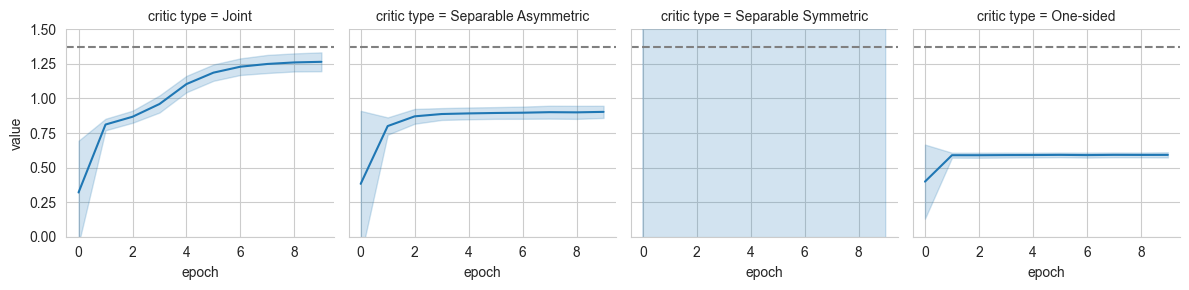

In [9]:
grid = sns.FacetGrid(pd_log[pd_log['name']=='mutual_information'], col='critic type', ylim=(0,1.5))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.refline(y=true_mi)

/tmp/ipykernel_298911/2202759378.py:17: RuntimeWarning: divide by zero encountered in divide
  ax[0].contourf(X, Y, log_ratio/mask, cmap='viridis', levels=40)
/tmp/ipykernel_298911/2202759378.py:23: RuntimeWarning: divide by zero encountered in divide
  ax[i+1].contourf(X, Y, unnormalized_ratio/mask, cmap='viridis', levels=40)


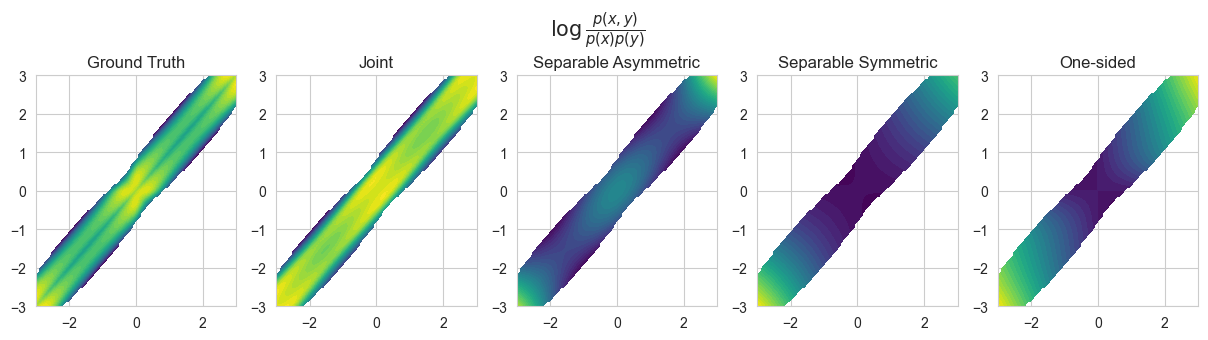

In [10]:
# We create a uniform grid to visualize the functions modeled by the critics
res = 100
x_grid = torch.linspace(-3,3,res).view(-1,1,1)
y_grid = torch.linspace(-3,3, res).view(1,-1,1)
X, Y = np.meshgrid(x_grid, y_grid)

# Compute the true log-ratio log p(x,y)p(x)p(y) on the grid
log_marginal = p_XY.marginal('x').log_prob(x=x_grid) +  p_XY.marginal('y').log_prob(y=y_grid)
log_joint = p_XY.log_prob(x=x_grid, y=y_grid)
# We visualize only the points for which p(x,y) > e^{-20}
mask = (log_joint>-20).data.numpy()
log_ratio = (log_joint - log_marginal).data.numpy()

# Plot the true log-ratio
f, ax = plt.subplots(1,len(critics)+1,figsize=((1+len(critics))*IMG_SIZE, IMG_SIZE))
f.suptitle("$\\log \\frac{p(x,y)}{p(x)p(y)}$", fontsize=15, y=1.1)
ax[0].contourf(X, Y, log_ratio/mask, cmap='viridis', levels=40)
ax[0].set_title('Ground Truth')

# And the unnormalized log-ratio modeled by the critics
for i, (name, critic) in enumerate(critics.items()):
    unnormalized_ratio = critic(x_grid, y_grid).data.numpy()
    ax[i+1].contourf(X, Y, unnormalized_ratio/mask, cmap='viridis', levels=40)
    ax[i+1].set_title(name)

 We can clearly notice how the more constrained architecture struggle to model the log-ratio for the given distribution. This translates into less-tight lower-bounds for $I(x;y)$.

## Estimating the log-partition function

One of the central challenges in the computation of mutual information lies in the estimation of the expected log-partition function $\mathbb{E}_{p(x)}\left[\log\mathbb{E}_{p(y)}[e^{F(x,y)}]\right]$.
Since the logarithm occurs outside the expectation w.r.t. $p(y)$, any naive batch-based estimation would result in a biased estimate.

To prevent this, it is possible to use the inequality $\log a(x) \le a(x)/e^b(x) + b(x) - 1$ to define an upper-bound that is tight for $b(x)=\log a(x)$ and valid for any `baseline` $b(x)$



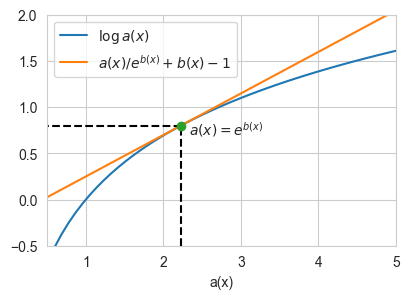

In [11]:
a = np.linspace(0.5, 5)
b = 0.8

f, ax = plt.subplots(1,1,figsize=(IMG_SIZE*1.5, IMG_SIZE))
ax.set_xlim(0.5,5)
ax.set_ylim(-0.5,2)
ax.set_xlabel('a(x)')


# Original value
plt.plot(a, np.log(a), label='$\\log a(x)$')

# Upper-bound
plt.plot(a, a/np.exp(b)+b-1, label='$a(x)/e^{b(x)} + b(x) - 1$')
plt.legend()

plt.plot([0, np.exp(b)],[b,b], ls='--', color='k')
plt.plot([np.exp(b), np.exp(b)],[-0.5,b], ls='--', color='k')
plt.plot(np.exp(b), b, 'o')
plt.text(np.exp(b)+0.1, b-0.1, '$a(x) = e^{b(x)}$');



This can be applied to the previous equation as follows:
$$
\mathbb{E}_{p(x)}\left[\log\underbrace{\mathbb{E}_{p(y)}[e^{F(x,y)}]}_{a(x)}\right] \le \mathbb{E}_{p(x)}\left[\frac{\mathbb{E}_{p(y)}[e^{F(x,y)}]}{e^{b(x)}}+b(x)\right]-1=  \mathbb{E}_{p(x)p(y)}\left[e^{F(x,y)-b(x)}+b(x)\right]-1 
$$
As a result, the expectation can be approximated with a batch of $N$ iid samples $(x_i,y_i)\stackrel{N}{\sim} p(x,y)$:
$$
\mathbb{E}_{p(x)p(y)}\left[e^{F(x,y)-b(x)}+b(x)\right] \approx \frac{1}{N}\sum_{i=1}^N\left[ b(x_i) + \frac{1}{M}\sum_{j=1}^M e^{F(x_i,y_{(i+j)\mod N})-b(x_i)}\right]
$$
in which $(i+j)\mod{N}$ is used to select the first $M$ elements in the batch starting from $i+1$, looping around for $i+j>N$. This is because the pair $(x_i,y_j)$ for $i\neq j$ can be considered as a sample from $p(x)p(y)$.


Several estimators in literature can be interpreted by considering different choices of baselines, which may differ at training and evaluation time, as summarized in the following table:

| Model     | Train $b(x_i)$                                                                                | Evaluation $b(x_i)$                                                   |
|-----------|-----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------|
| NWJ       | $1$                                                                                           | Same as Train                                                         |
| MINE      | $\log EMA\left(\frac{1}{NM}\sum_{k=1}^N\sum_{j=1}^M e^{F(x_k,y_{(k+j)\mod N})},\gamma\right)$ | $\log\frac{1}{MN}\sum_{k=1}^N\sum_{j=1}^M e^{F(x_k,y_{(k+j)\mod N})}$ |
| InfoNCE   | $\log\frac{1}{M}\sum_{j=1}^M e^{F(x_i,y_{(i+j)\mod N})}$                                      | Same as Train                                                         |
| TUBA      | $b_\psi(x_i)$                                                                                 | Same as Train                                                         |
| AlphaTuba | $\alpha\log\frac{1}{M}\sum_{j=1}^M e^{F(x_i,y_{(i+j)\mod N})}+(1-\alpha) b_\psi(x_i)$         | Same as Train                                                         | 


`torch_mist` includes implementations of the aforementioned estimators, but different baselines can also be instantiated explicitly.

In [12]:
from torch_mist.baseline import ConstantBaseline, ExponentialMovingAverage, baseline_nn, InterpolatedBaseline

# some example baselines
baselines = {
    'Constant': ConstantBaseline(1),                        # NWJ baseline
    'EMA': ExponentialMovingAverage(gamma=0.9),             # MINE baseline (training)
    'Learnable': baseline_nn(                               # TUBA baseline
        x_dim=x_dim,
        hidden_dims=[32, 32],    
    ),
    'Interpolated': InterpolatedBaseline(                   # Custom interpolated baseline 
        baseline_1=ExponentialMovingAverage(gamma=0.9),     # alpha * EMA +
        baseline_2=baseline_nn(                             # (1-alpha) * LearnableBaseline(x)
            x_dim=x_dim,
            hidden_dims=[32, 32],    
        ),
        alpha=0.5
    )
}

for name, baseline in baselines.items():
    n_params = sum([param.numel() for param in baseline.parameters()])
    print(f"{name} baseline, {n_params} Parameters")

Constant baseline, 0 Parameters
EMA baseline, 0 Parameters
Learnable baseline, 1153 Parameters
Interpolated baseline, 1153 Parameters


In [13]:
from torch_mist.estimators.discriminative import BaselineDiscriminativeMIEstimator
from torch_mist.critic import joint_critic
from copy import deepcopy


pd_log = pd.DataFrame()

# We instantiate a simple critic architecture
critic = joint_critic(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=[64, 64],
)

# We can train all the estimators
for name, baseline in baselines.items():
    estimator = BaselineDiscriminativeMIEstimator(
        critic=deepcopy(critic),
        baseline=baseline,
        neg_samples=32
    )
    print(f"Training the MI estimator with the {name} baseline")
    train_log = train_mi_estimator(
        estimator=estimator,
        x=samples['x'], y=samples['y'],
        **train_parameters           
    )
    train_log['baseline type'] = name
    pd_log = pd.concat([pd_log, train_log])

Training the MI estimator with the Constant baseline


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training the MI estimator with the EMA baseline


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training the MI estimator with the Learnable baseline


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training the MI estimator with the Interpolated baseline


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


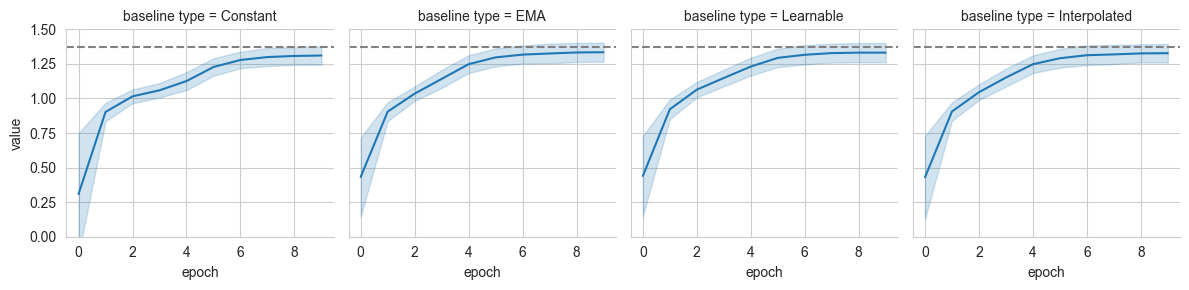

In [14]:
grid = sns.FacetGrid(pd_log[pd_log['name']=='mutual_information'], col='baseline type', ylim=(0,1.5))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.refline(y=true_mi)

### Number of Negative Samples


We refer to $M$ as `neg_samples` to indicate the number of "negative samples" that are used for each element of the batch. In other words, `neg_samples` regulates how many $y_j$ are used for each $x_i$ in the batch for the estimation of the expectation above.

The value of `neg_samples` is capped by the `batch_size`. A value of `neg_samples=0` is used to specify that the summation over $j$ should go over the whole batch (including $i=j$), negative values are used to specify the number of relative negative samples with respect to the current batch size.
E.g. `neg_samples=-10` will use `batch_size-10` negative samples for each $x_i$ (with a minimum of 1 if the `batch_size` is 10 or less).

Note that the number of negative samples impacts the memory usage, computational cost for training and evaluation, the variance, and convergence speed of the estimators. More negative samples increase the costs but tend to improve the quality of the estimation.

We demonstrate this behaviour by training the simple `NWJ` estimator far various number of `neg_samples` 


In [15]:
pd_log = pd.DataFrame()

# Train the estimator with different amounts of negative samples
n_negatives = [1, 4, 16, 64]
for neg_samples in n_negatives:
    estimator = NWJ(
        critic=deepcopy(critic),
        neg_samples=neg_samples
    )
    print(f"Training the MI estimator with {neg_samples} negative sample(s)")
    train_log = train_mi_estimator(
        estimator=estimator,
        x=samples['x'], y=samples['y'],
        **train_parameters           
    )
    train_log['negative samples'] = neg_samples
    pd_log = pd.concat([pd_log, train_log])

Training the MI estimator with 1 negative sample(s)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training the MI estimator with 4 negative sample(s)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training the MI estimator with 16 negative sample(s)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training the MI estimator with 64 negative sample(s)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


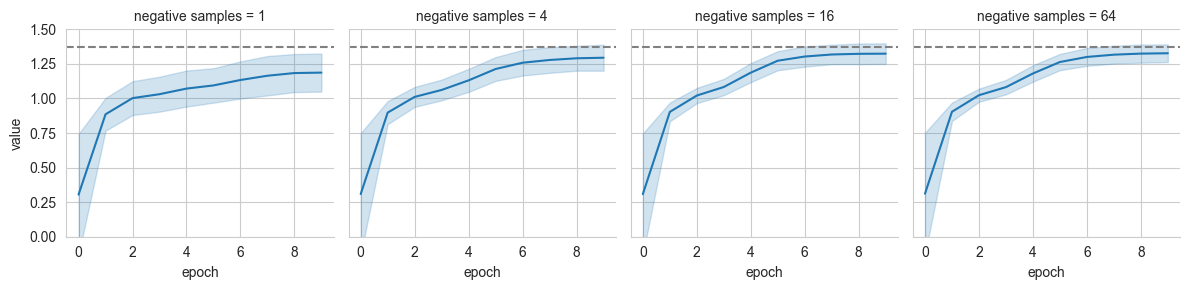

In [17]:
grid = sns.FacetGrid(pd_log[pd_log['name']=='mutual_information'], col='negative samples', ylim=(0,1.5))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.refline(y=true_mi)

## Alternative Training objectives

Estimating the expected log-partition function becomes quite challenging for large values of $I(x;y)$ since the variance of $e^{\hat F(x,y)}$ with respect to the product distribution $p(x)p(y)$ and the optimal critic $\hat F(x,y)$ grows exponentially with $I(x;y)$. One possible work-around involves optimizing the critic $F(x,y)$ to 
maximize the Jensen-Shannon (JS) divergence instead:
$$
JS(p(y|x)||p(y)) \ge \max_{F} \mathbb{E}_{p(x,y)}[\log \sigma(F(x,y))] + \mathbb{E}_{p(x)p(y)}[\log (1-\sigma(F(x,y)))] + 2\log2.
$$
The optimal critic is given by:
$$
\hat F^{JS}(x,y) = \log\frac{p(y|x)}{p(y)} + 1
$$
On the other hand, we know that log-ratio between $p(y|x)$ and $p(y)$ is an optimal critic for the dual KL divergence:
$$
\hat F^{KL}(x,y) = \log\frac{p(y|x)}{p(y)},
$$
Therefore we can use $\hat F^{KL}(x,y) = \hat F^{JS}(x,y) - 1$ into the dual expression of KL to obtain a MI estimator
$$
I(x;y) =  \mathbb{E}_{p(x,y)}[\hat F^{JS}(x,y)-1] - \mathbb{E}_{p(x)}\left[\log\mathbb{E}_{p(y)}[e^{\hat F^{JS}(x,y) - 1}]\right] = \mathbb{E}_{p(x,y)}[\hat F^{JS}(x,y)] - \mathbb{E}_{p(x)}\left[\log\mathbb{E}_{p(y)}[e^{\hat F^{JS}(x,y)}]\right].
$$

This implies that we can optimize $F(x,y)$ using then dual expression for the JS divergence and then use it for the estimation of KL. The training procedure for the dual expression of the JS divergence is generally more stable, but suboptimal critics may result in under-estimation of the true value of MI.

This strategy is used in practice by the `JS` and `SMILE` estimators that use the same baselines as `NWJ` and `MINE` respectively for evaluation. 


In [19]:
from torch_mist.estimators.discriminative import JS, SMILE

pd_log = pd.DataFrame()

estimators = {
    'JS': JS(
        critic = deepcopy(critic),
        neg_samples=32,
    ),
    'SMILE': SMILE(
        critic = deepcopy(critic),
        neg_samples=32,
        # Smile additionally clips the values of F(x,y) into the interval [-\tau, \tau]
        tau=5  
    )
}

# We can train all the estimators
for name, estimator in estimators.items():
    print(f"Training the {name}  MI estimator")
    train_log = train_mi_estimator(
        estimator=estimator,
        x=samples['x'], y=samples['y'],
        **train_parameters           
    )
    train_log['estimator'] = name
    pd_log = pd.concat([pd_log, train_log])

Training the JS  MI estimator


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training the SMILE  MI estimator


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

/home/marco/.cache/pypoetry/virtualenvs/torch-mist-77TFSLfY-py3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


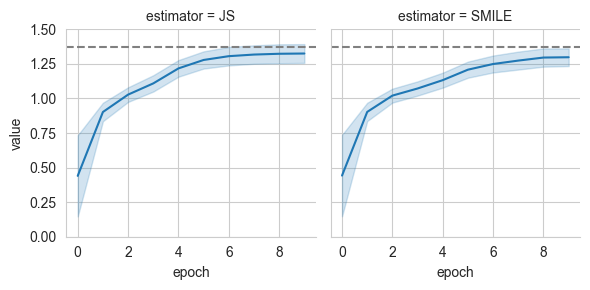

In [20]:
grid = sns.FacetGrid(pd_log[pd_log['name']=='mutual_information'], col='estimator', ylim=(0,1.5))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.refline(y=true_mi)